In [1]:
# test_imports in this cell, restart kernel whenever edits to modules are made

import sys
import os
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

#import config based on which machine the jupyter notebook is running on
from configs.config_local import *
from preprocessing import *
from module_detection import *
from utils import *

def test_imports():
    print("testing config class")
    config = Config()
    print(config)

    print("testing 2d contacts preprocessing classes")
    query = HiCQuery(config, 'chr1', 1000000, '1Mb') #needs config, chrom and res/res0 for instantiation
    print(query)

    
    #other prints for imported classes

test_imports()

testing config class
testing 2d contacts preprocessing classes
HiC file loaded


## OE part of the pipeline

In [2]:
#initialising parameters for single chromosome analysis

config = Config()
chrom = config.genomic_params.chromosomes[0]
current_res = config.genomic_params.resolutions[0]  # 1Mb for OE part
current_res_str = config.genomic_params.res_strs[0]  # 1Mb for OE part
query = HiCQuery(config, chrom, current_res, current_res_str)

HiC file loaded


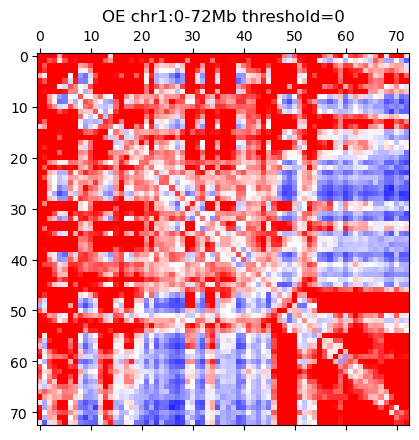

In [3]:
## TRYING DIFFERENT THRESHOLDS ##

# params for OE matrix visualisation
threshold = 0
start = 0
end = 72000000
# Directory to save plots
output_dir = os.path.join(config.paths.temp_dir, f"oe_plots_{threshold}")
os.makedirs(output_dir, exist_ok=True)

# Custom colormap
REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1, 1, 1), (1, 0, 0)])

## single chr visualisation ##
oe_numpy_thresholded = query.oe_intra_numpy(start, end, threshold)
region_str = format_loci_string(start, end, current_res_str) 

def plot_single_hic_map(dense_matrix, cmap, vmin=0, vmax=30, title=""):
    d2 = dense_matrix
    d2[np.isnan(d2)] = 0
    d2[np.isinf(d2)] = 0
    plt.matshow(dense_matrix, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.show()

plot_single_hic_map(oe_numpy_thresholded, 'bwr', 0, 1, f"OE {chrom}:{region_str} threshold={threshold}")

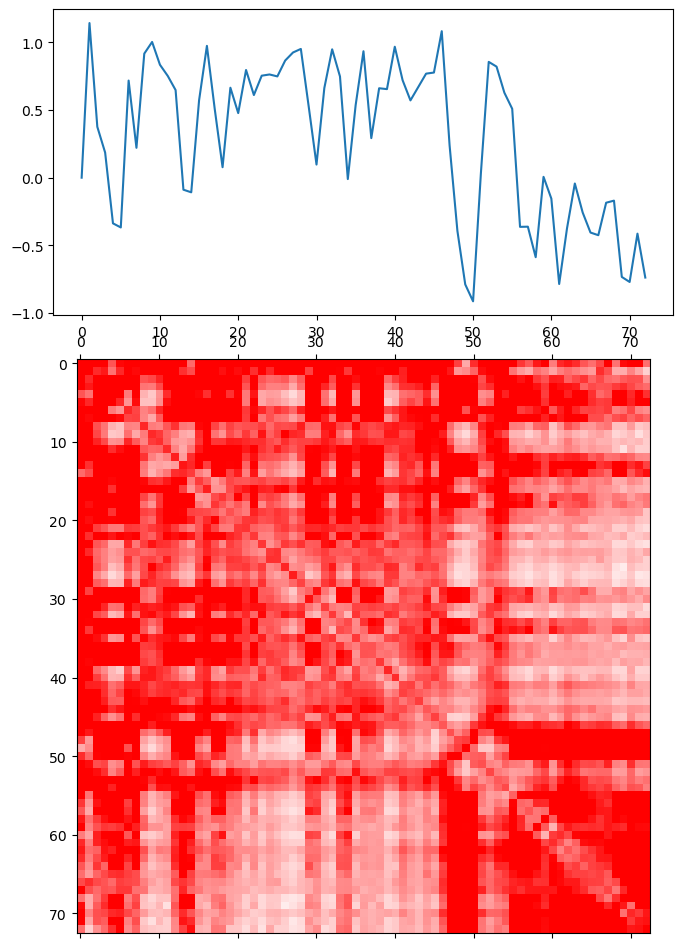

In [4]:
## Plot AB score with hic oe to see if +:A and -:B strategy is good or not##

def plot_2dhic_1dtrack_map(dense_matrix, signal, vmin, vmax, cmap):
  d2 = dense_matrix # np.log(dense_matrix)
  d2[np.isnan(d2)] = 0
  d2[np.isinf(d2)] = 0
  fig = plt.figure()
  fig.set_figheight(12)
  fig.set_figwidth(8)
  spec = gridspec.GridSpec(ncols=1, nrows=2,
                         width_ratios=[1], wspace=1,
                         hspace=.1, height_ratios=[16, 30])
  ax0 = fig.add_subplot(spec[0])
  ax0.plot(np.arange(len(signal)), signal)
  ax1 = fig.add_subplot(spec[1])
  ax1.matshow(d2, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.show()

# params for AB score visualisation along with OE matrix
ab_geo_bw = pyBigWig.open(config.paths.compartments_infile)
nm_bins = oe_numpy_thresholded.shape[0]
signal = ab_geo_bw.stats(
                chrom, start, end, type="mean", nBins=nm_bins
            )
#filter none values
filtered_signal = [0 if x is None else x for x in signal]
plot_2dhic_1dtrack_map(oe_numpy_thresholded, filtered_signal, 0, 1, REDMAP)

Filename: /Users/Akanksha/MaGroup/Genomic Hubs/3D_chromatin_hubs/src/preprocessing/hic_data_loader.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   141    257.3 MiB    257.3 MiB           1       @profile
   142                                             def oe_intra(self, threshold=0):
   143                                                 """
   144                                                 returns contact records for one chromosome as straw object, thresholded if needed
   145                                                 straw object : .binX [0] .binY [1] .counts [2] as attributes of list
   146                                                 """
   147    257.3 MiB      0.0 MiB           1           chrom = self.chrom[3:]
   148    257.3 MiB      0.0 MiB           1           res = int(self.res)
   149    259.4 MiB      2.1 MiB           2           oe_list = hicstraw.straw(
   150    257.3 MiB      0.0 MiB           1               "oe", self.hic_norm

/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_93872/1008850441.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(


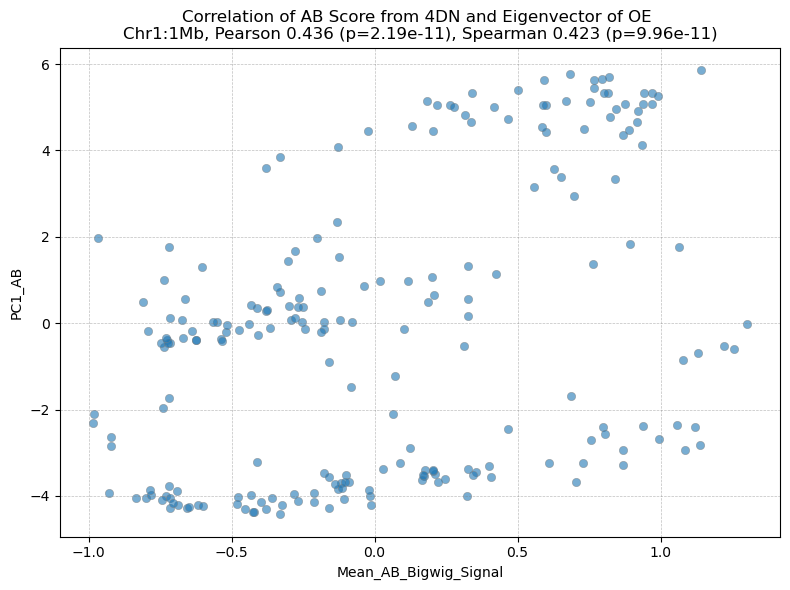

In [5]:
def plot_ab_score_correlation_scatter(correlation_data, pearson_corr, pearson_p, spearman_corr, spearman_p):
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(
        data=correlation_data, 
        x='Mean_AB_Bigwig_Signal', 
        y='PC1_AB', 
        palette={False: 'green', True: 'red'}, 
        legend='full',
        edgecolor='grey',  # Grey borders
        alpha=0.6
    )
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    handles, labels = scatter.get_legend_handles_labels()
    plt.title(f'Correlation of AB Score from 4DN and Eigenvector of OE \nChr1:1Mb, Pearson {pearson_corr:.3f} (p={pearson_p:.2e}), Spearman {spearman_corr:.3f} (p={spearman_p:.2e})')
    plt.xlabel('Mean_AB_Bigwig_Signal')
    plt.ylabel('PC1_AB')
    plt.tight_layout()
    plt.show()


## Get AB scores of the intra-chr OE matrix ##
oe_intra_csr = query.oe_straw_to_csr()
ab_score_dict = query.ab_comp.calculate_ab_score(oe_intra_csr) #send sparse matrix to calculate whole chr ab_score
print(ab_score_dict)
bigwig_signal_dict = query.ab_comp.load_bigwig_chromosomal_ab()
print(bigwig_signal_dict)

correlation_data, pearson_corr, pearson_p, spearman_corr, spearman_p = query.ab_comp.ab_score_correlation(ab_score_dict, bigwig_signal_dict)
# get outliers
#correlation_data['Outliers'] = (correlation_data['PC1_AB'] > 3) | (correlation_data['Mean_AB_Bigwig_Signal'].abs() > 0.0015)
#plot
plot_ab_score_correlation_scatter(correlation_data, pearson_corr, pearson_p, spearman_corr, spearman_p)

## Cluster accuracy and metrics

HiC file loaded


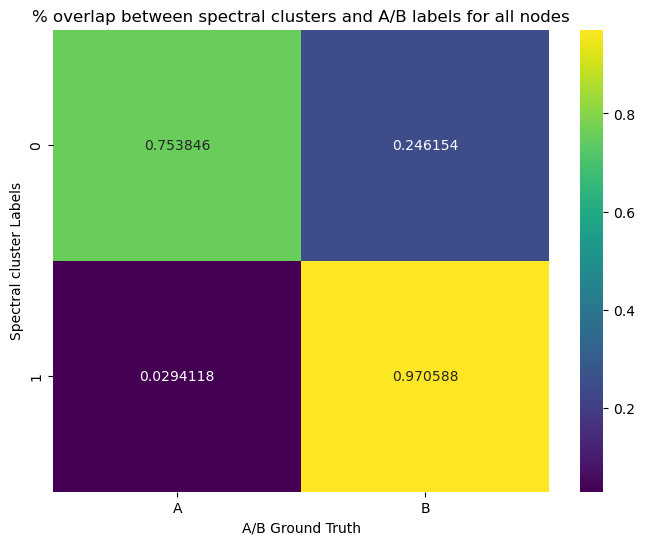

In [22]:
## plot confusion matrix between cluster labels and ab scores ##
##### DEBUG : the conf matrix varies on each execution, need to fix this #####

def plot_confusion_matrix_heatmap(confusion_matrix):
    """
    Plot the confusion matrix as a heatmap.

    Parameters:
    confusion_matrix (numpy.ndarray): A 2x2 confusion matrix.
    """
    #normalize the confusion matirx
    cnf_mtx_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    gt_labels = ['A', 'B']
    cluster_labels = ['0', '1']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cnf_mtx_norm, annot=True, fmt='g', cmap='viridis', xticklabels=gt_labels, yticklabels=cluster_labels)
    plt.xlabel('A/B Ground Truth')
    plt.ylabel('Spectral cluster Labels')
    plt.title('% overlap between spectral clusters and A/B labels for all nodes')
    plt.show()

config = Config()
conf_matx = run_single_chrom("chr1", config, 1000000, "1Mb")
plot_confusion_matrix_heatmap(conf_matx)

In [ ]:
## plot cluster_size split between A and B 